<a href="https://colab.research.google.com/github/05satyam/AI-ML/blob/main/webcrawler_agentic_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Web Crawler Agentic System

## Introduction
- The Web Crawler Agentic System is designed to automate the process of gathering information from the web using an agentic AI approach.
- This system leverages agents, which are autonomous entities responsible for performing specific tasks, to extract, process, and retrieve data from websites.
-The system incorporates a web crawler that collects structured or unstructured data from specified URLs, enabling efficient information retrieval and data analysis.

## The app consists of three primary components:

- Web Crawler: Collects textual data from the specified URLs.
- Vector Store: Stores the extracted information in a vector database for efficient retrieval.
- Multi-Agent Query System: Interacts with the crawled data using different agent types to process user queries and provide answers.


## Prerequisites
- Before running the notebook, ensure that you have the following libraries installed:
- Streamlit: A framework to build and deploy web applications.
- LangChain: A language model framework to manage tools, chains, and agents.
- OpenAI: To interact with OpenAI's GPT models.
- Chroma: A vector store implementation used to store embeddings.
- DuckDuckGoSearchResults: For conducting web searches when data is unavailable in the vector store.
- BeautifulSoup: To parse and extract data from web pages.
- pyngrok: For exposing the app via a public URL using ngrok.
- psutil: To manage and kill processes on the server.

## Query System
- The application supports different agent types that interact with both the vector store and external web search tools:

- Zero-Shot React Agent: Answers queries using the stored data in the vector store.
- Conversational React Agent: Supports multi-turn dialogue where the context of the conversation is preserved.
- Structured Chat Zero-Shot Agent: Provides structured responses for complex queries.

## Usage:
- Application is particularly useful for retrieving information from multiple sources and answering complex questions based on both crawled and live web data.



In [ ]:
!pip install requests beautifulsoup4 streamlit python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
!pip install pyngrok streamlit


In [ ]:
!pip install --upgrade langchain
!pip install langchain llama-index chromadb openai python-dotenv langchain-community
!pip install -qU "langchain-chroma>=0.1.2"
!pip install -U duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.2/396.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.8 MB/s eta 0:0

In [ ]:
%%writefile app.py
import os
import requests
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import streamlit as st
from langchain.chains import VectorDBQA
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.tools import DuckDuckGoSearchResults
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI
from langchain_chroma import Chroma
from langchain.schema import Document
from pyngrok import ngrok
import signal
import psutil
from urllib.parse import urljoin

# Load environment variables
load_dotenv()

# Initialize embeddings function
embeddings_fn = OpenAIEmbeddings(model="text-embedding-ada-002", )

# Initialize Chroma vector store
vector_store = Chroma(
    collection_name="web-crawl-vecstore",
    embedding_function=embeddings_fn,
    persist_directory="./chroma_db",
)

# Define a simple web crawler
def crawl_and_extract_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract all text from the page
    text = soup.get_text(separator=' ', strip=True)

    # Create a document
    document = Document(page_content=text, metadata={'source': url})
    return document

# Function to persist crawled data into ChromaDB
# def persist_crawled_data(urls):
#     documents = []
#     for url in urls:
#         document = crawl_and_extract_text(url)
#         documents.append(document)
#     st.text_input(f"Crawled {len(documents)} documents:{documents}.")
#     # Embed and store documents in the vector store
#     for i, doc in enumerate(documents):
#         metadata = {
#             'url': doc.metadata['source'],
#             'text': doc.page_content[:500]
#         }
#         vector_store.add_texts(
#             texts=[doc.page_content],
#             metadatas=[metadata],
#             ids=[str(i)]
#         )
#     return documents
def crawl_and_extract_text(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract all links and their corresponding text
    documents = []
    base_url = url.rstrip('/')

    for link in soup.find_all('a', href=True):
        full_link = link['href']
        # Convert relative URL to absolute URL
        full_link = urljoin(base_url, full_link)

        try:
            link_response = requests.get(full_link)
            link_soup = BeautifulSoup(link_response.text, 'html.parser')
            link_text = link_soup.get_text(separator=' ', strip=True)

            document = Document(
                page_content=link_text,
                metadata={'source': full_link, 'topic': link.get_text(strip=True)}
            )
            documents.append(document)
        except requests.RequestException as e:
            st.write(f"Failed to crawl {full_link}: {e}")

    return documents
def persist_crawled_data(urls):
    all_documents = []
    for url in urls:
        # Ensure URL starts with http:// or https://
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url

        documents = crawl_and_extract_text(url)
        all_documents.extend(documents)
        st.write(f"Crawled {len(documents)} documents from {url}.")

    # Embed and store documents in the vector store
    for i, doc in enumerate(all_documents):
        metadata = {
            'url': doc.metadata['source'],
            'text': doc.page_content[:500]  # Store a snippet of the text for metadata
        }
        vector_store.add_texts(
            texts=[doc.page_content],
            metadatas=[metadata],
            ids=[str(i)]
        )

    return all_documents

# Initialize language model
llm = ChatOpenAI(model="gpt-4", temperature=0, openai_api_key=os.getenv("OPENAI_API_KEY"))

# Load a question-answering chain
combine_documents_chain = load_qa_chain(llm, chain_type="map_reduce", return_intermediate_steps=False)

qa_chain = VectorDBQA(
    vectorstore=vector_store,
    combine_documents_chain=combine_documents_chain,
    k=5,
    return_source_documents=False,
    verbose=True
)

# Set up tools for the agent
web_search = DuckDuckGoSearchResults(k=1)
tools = [
    Tool(
        name="vec_search",
        func=lambda tool_input: qa_chain({"query": tool_input})['result'],
        description="Search the vector database and provide a detailed explanation and relevant documentation."
    ),
    Tool(
        name="Web Search",
        func=lambda tool_input: web_search.run(tool_input),
        description="Search the web if the information is not found in the vector store and provide a detailed explanation and relevant documentation."
    ),
    Tool(
        name="Explain and Document",
        func=lambda tool_input: f"Here is a detailed explanation and documentation for the query: {tool_input}.",
        description="Provide a detailed explanation and relevant documentation."
    )
]

chat_history = [] # for conversational

# Initialize agents
zero_shot_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

react_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.CONVERSATIONAL_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

structured_chat_agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

# Streamlit app
st.title("Web Crawler and Multi-Agent AI Query System")

# URL input for crawling
urls = st.text_area("Enter URLs to crawl (one per line):")

if st.button("Crawl and Persist Data"):
    urls_list = urls.splitlines()
    persisted_documents = persist_crawled_data(urls_list)
    st.write(f"Persisted {len(persisted_documents)} documents in the vector store.")

query = st.text_input("Enter your query:")

agent_option = st.selectbox(
    "Choose an agent type:",
    ("Zero-Shot React", "Conversational React", "Structured Chat Zero-Shot")
)

if st.button("Run Query"):
    if agent_option == "Zero-Shot React":
        response = zero_shot_agent.run(query)
    elif agent_option == "Conversational React":
        response = react_agent.run({"input":query, "chat_history": chat_history})
        chat_history.append({"role": "user", "content": query})
        chat_history.append({"role": "assistant", "content": response})
    elif agent_option == "Structured Chat Zero-Shot":
        response = structured_chat_agent.run(query)

    st.write("### Response")
    st.write(response)

# Function to stop the server and ngrok
def stop_server():
    # Kill the process running on port 8501 (Streamlit's default port)
    for proc in psutil.process_iter():
        for conns in proc.connections(kind="inet"):
            if conns.laddr.port == 8501:
                proc.send_signal(signal.SIGTERM)  # or signal.SIGKILL

    # Disconnect the ngrok tunnel
    ngrok.kill()

# Add a button to stop the server
if st.button("Stop and Restart"):
    stop_server()
    st.write("Server stopped. Please restart manually.")




Overwriting app.py


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token('') #api key for ngrock

In [ ]:
#SAMPLE RUN for TESTINGGGGG

# Test the QA chain
test_query = "What is LangChain's VectorDBQA?"
response = zero_shot_agent.run(test_query)
print("Response:", response)


print("="*100)

chat_history = []
test_query = "react_agent. What is LangChain's VectorDBQA?"
response = react_agent.run({"input":test_query, "chat_history": chat_history})
chat_history.append({"role": "user", "content": test_query})
chat_history.append({"role": "assistant", "content": response})

print("Response:", response)



print("="*100)

test_query = "What is LangChain's VectorDBQA?"

response = structured_chat_agent({
  "input": test_query
});
print("Response:", response)






> Entering new AgentExecutor chain...
I'm not sure what LangChain's VectorDBQA is. I should search for it in the vector database first.
Action: vec_search
Action Input: LangChain's VectorDBQA

> Entering new VectorDBQA chain...



> Finished chain.

Observation: The document does not provide any information on LangChain's VectorDBQA.
Thought:The vector database did not provide any information. I should try searching the web next.
Action: Web Search
Action Input: LangChain's VectorDBQA
Observation: [snippet: Nov 17, 2023. LangChain is well-known for orchestrating interactions with large language models (LLMs). Recently, LangChain has introduced a way to perform self-querying, allowing them to query ..., title: Using LangChain to Self-Query a Vector Database - Medium, link: https://medium.com/@zilliz_learn/using-langchain-to-self-query-a-vector-database-da004eea4e47], [snippet: The vector store can be used to create a retriever as well. retriever = db.as_retriever()matched_docs = retriever.get_relevant_documents(query=query) To optimize the retrieval process, we can use ..., title: Retrieval in LangChain: Part 3— Text Embeddings and Vector Stores, link: https://medium.com/@sushmithabhanu24/retrieval-in-langchain-


> Finished chain.

Observation: The document does not provide any information on LangChain's VectorDBQA.
Thought:The vec_search tool did not provide any results. I will now use the Web Search tool to find more information about LangChain's VectorDBQA.
Action:
```
{
  "action": "Web Search",
  "action_input": "LangChain's VectorDBQA"
}
```
Observation: [snippet: LangChain is one of the most popular frameworks for building applications with large language models (LLMs). This blog post is a guide to building LLM applications with the LangChain framework in Python. We will use PostgreSQL and pgvector as a vector database for OpenAI embeddings of data. We'll use the example of creating a chatbot to answer ..., title: How to Build LLM Applications With pgvector Vector Store in LangChain, link: https://www.timescale.com/blog/how-to-build-llm-applications-with-pgvector-vector-store-in-langchain/], [snippet: Vector DBs find their integration with Langchain whenever the user wishes to provide s

In [ ]:
# Start ngrok tunnel
public_url = ngrok.connect(8501)
print(f"Streamlit app is live at {public_url}")

# Run the Streamlit app
!streamlit run app.py &>/dev/null&


Streamlit app is live at NgrokTunnel: "https://edb2-35-229-133-147.ngrok-free.app" -> "http://localhost:8501"


# OUTPUT

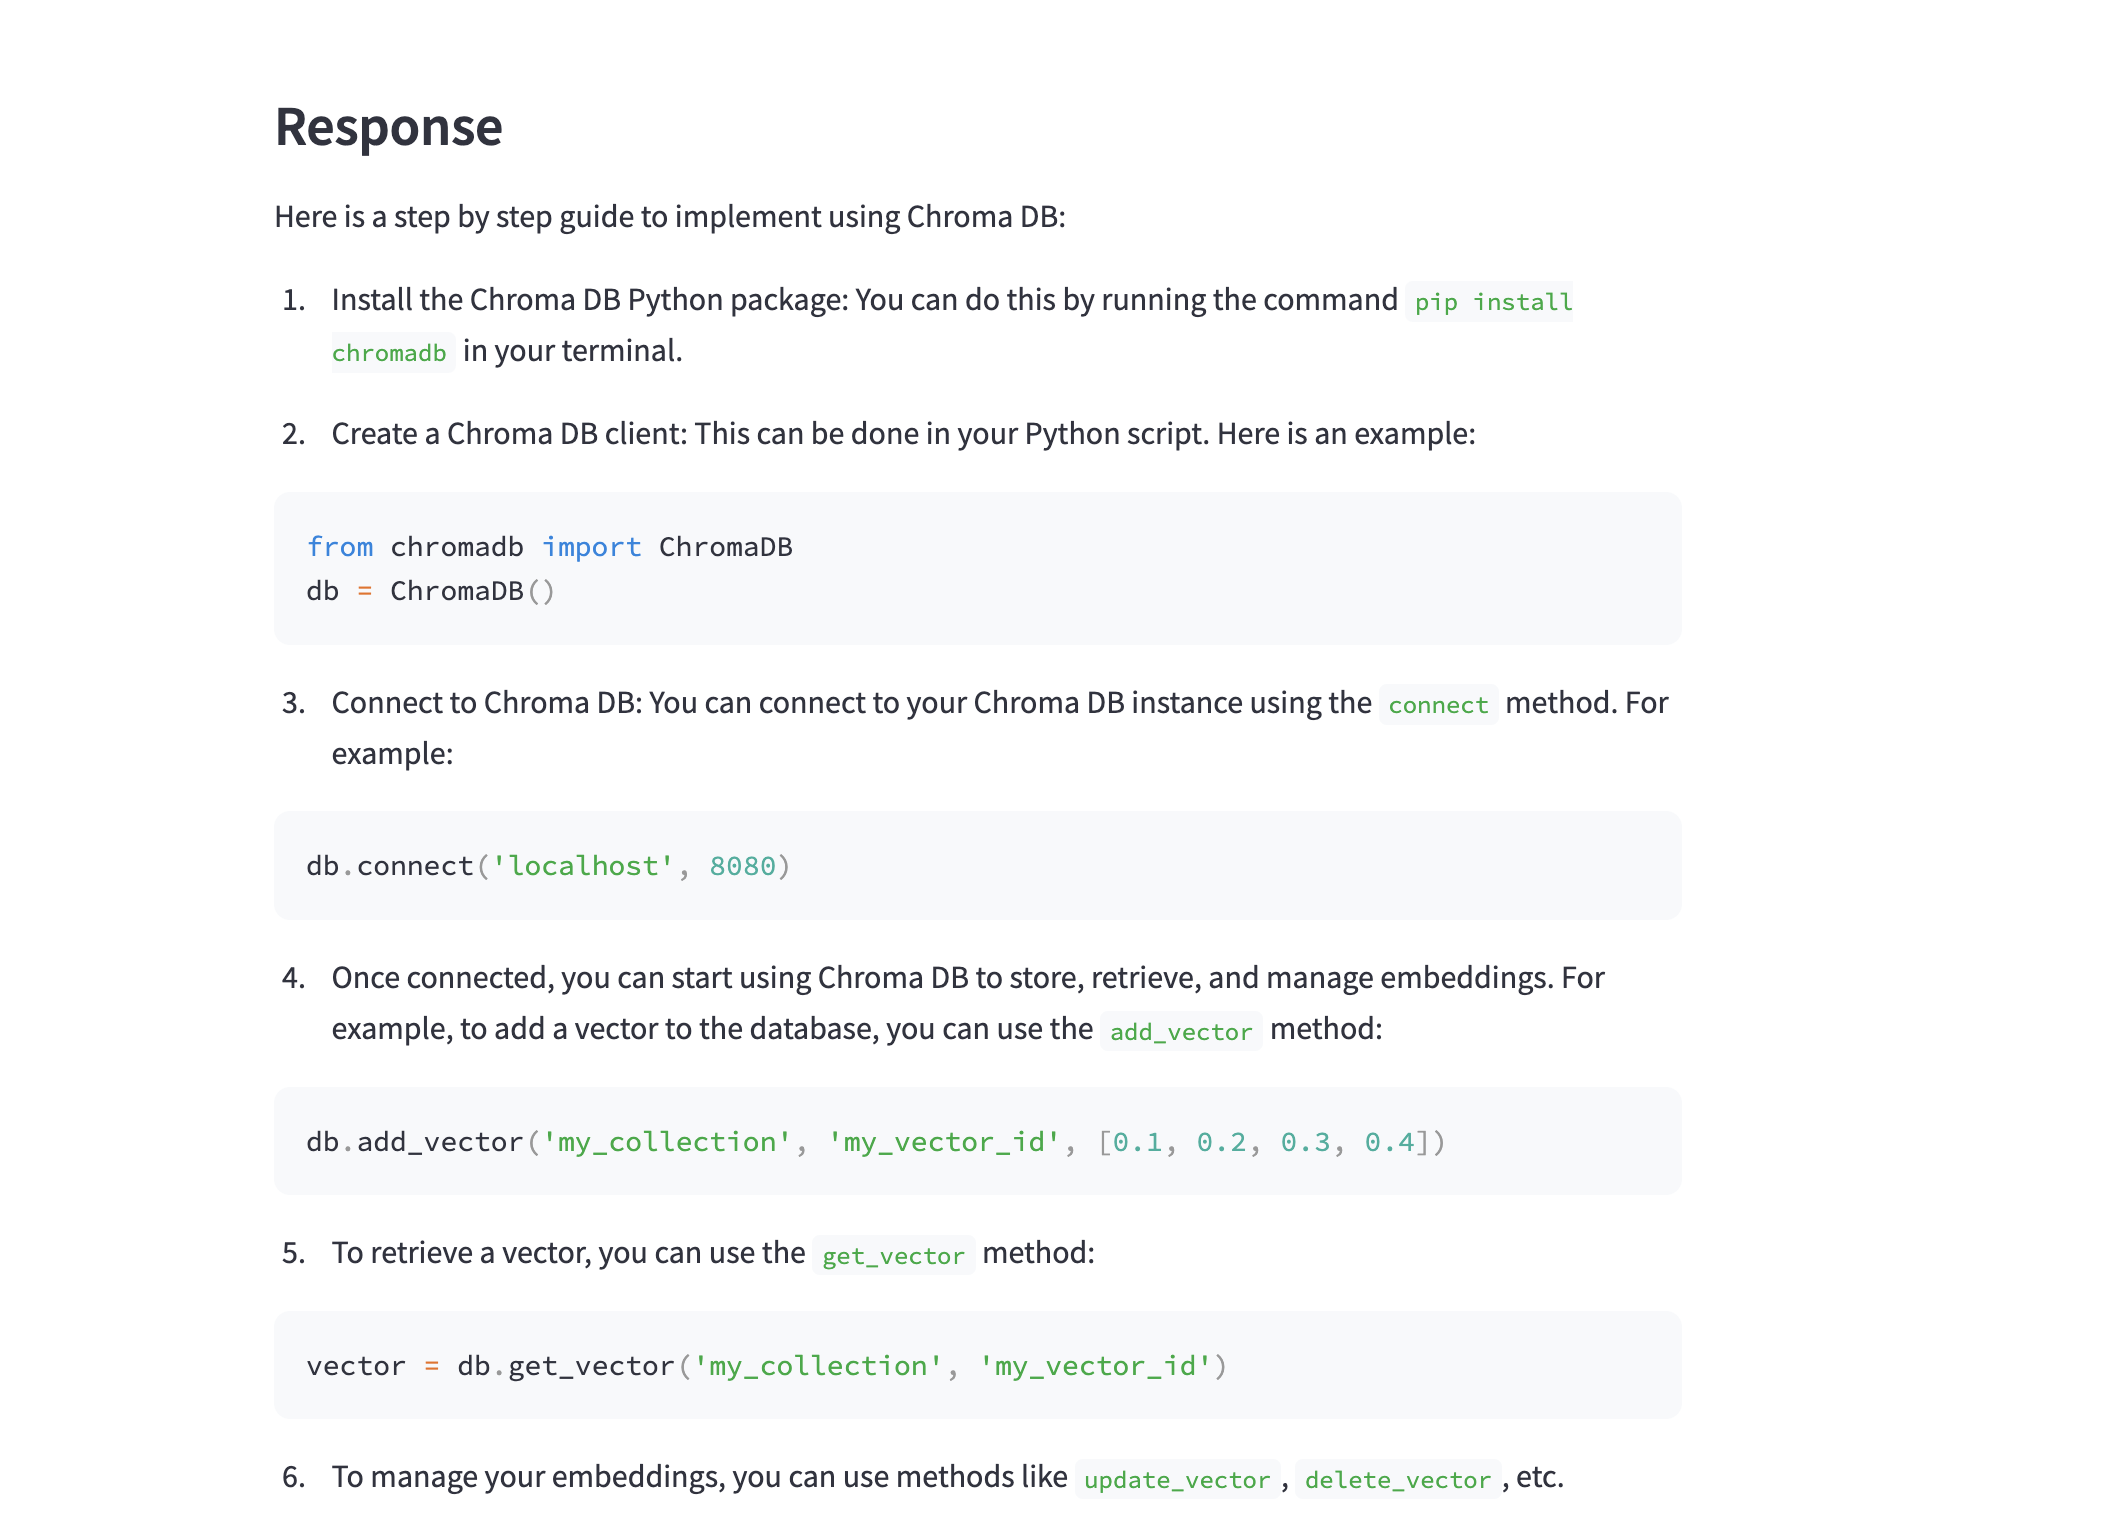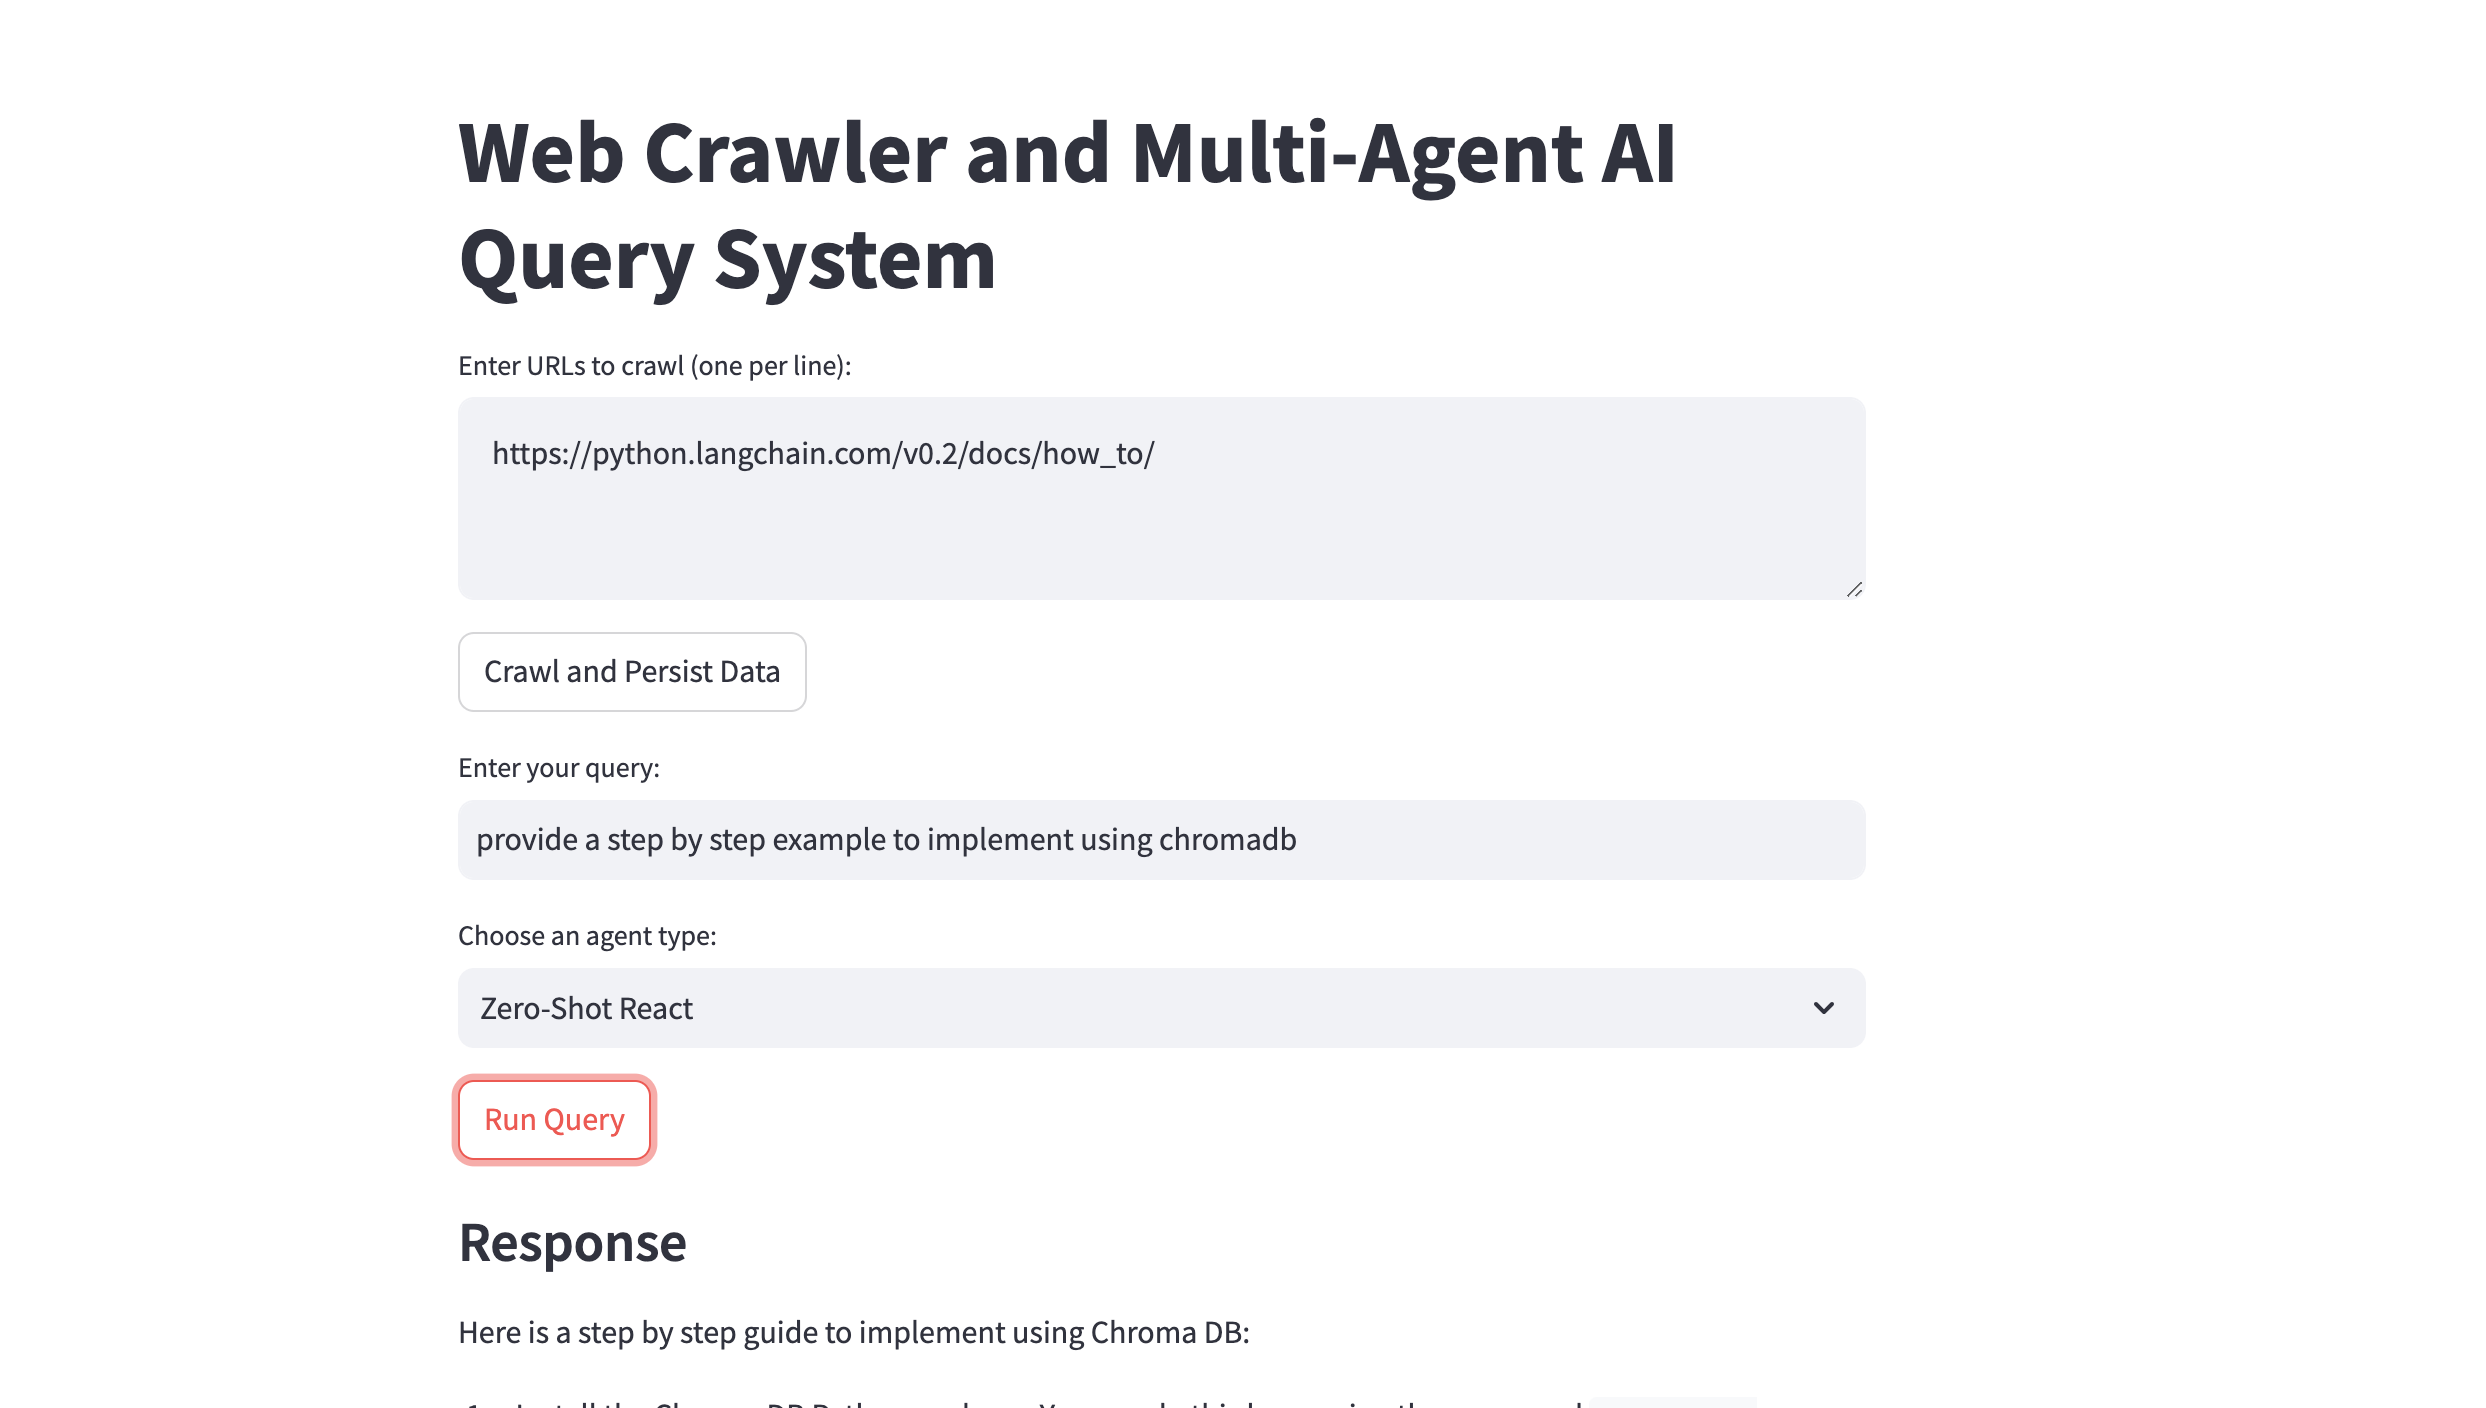